In [2]:
import Ipynb_importer
import Classic
import Subsetselection
import k2k_hadamard
import timeit
import scipy.io as io
import datetime

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import scipy.io as io

def generate_geometric_distribution(k,lbd):
    elements = range(0,k)
    prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
    return prob

def generate_uniform_distribution(k):
    raw_distribution = [1] * k
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

def generate_two_steps_distribution(k):
    raw_distribution = [1] * int(k/2) + [3] * int(k/2)
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

def generate_Zipf_distribution(k,lbd):
    raw_distribution = [1/(float(i)**(lbd)) for i in range(1,k+1)]
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

def generate_Dirichlet_distribution(k,lbd):  
    raw_distribution = [0] * k
    for i in range(0,k):
        raw_distribution[i] = np.random.gamma(1,1)
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

importing Jupyter notebook from Classic.ipynb
importing Jupyter notebook from Subsetselection.ipynb
importing Jupyter notebook from k2k_hadamard.ipynb


In [11]:
def test(k,eps,rep,points,step_sz,init,dist):  
    print(k)
    print(eps)
    indicies = [(init-1+i)*step_sz for i in range(1,points+1) ] # all the indicies
    a = Subsetselection.Subsetselection(k,eps) #class for subset selection algorithm
    b = k2k_hadamard.Hadamard_Rand_2(k,eps) #class for hadamard response
    prob1 = generate_uniform_distribution(k)
    prob2 = generate_two_steps_distribution(k)
    prob3 = generate_Zipf_distribution(k,1.0)
    prob4 = generate_Dirichlet_distribution(k,1.0)
    prob5 = generate_geometric_distribution(k,0.8)

    prob_list = {
        'Uniform' : prob1,
        'Two_steps' : prob2,
        'Zipf' : prob3,
        'Dirchlet' : prob4,
        'Geometric' : prob5, 
        }

    prob = prob_list[dist]

    l1_1 = [0]*points
    l1_2 = [0]*points
    l1_3 = [0]*points
    l1_4 = [0]*points

    t1_1 = [0]*points
    t1_2 = [0]*points
    t1_3 = [0]*points
    t1_4 = [0]*points

    for r in range(init, points + init):
        print(r)
        n = r*step_sz
        count1 = 0
        count2 = 0
        count3 = 0
        count4 = 0
        t1 = 0
        t2 = 0
        t3 = 0
        t4 = 0
        for t in range(0,rep):
            #print(t)
            elements = range(0,k)
            in_list = np.random.choice(elements, n, p=prob) #input symbols

            outp_1 = a.encode_string(in_list) #subset selection
            start_time = timeit.default_timer()
            prob_est_1 = a.decode_string(outp_1,n) # estimate the original underlying distribution
            t1 = t1 + timeit.default_timer() - start_time
            count1 = count1 + np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est_1)], ord=1)       

            sample = Classic.randomized_response_encoder(in_list, eps, k) # krr
            start_time = timeit.default_timer()
            (outp_2, temp) = np.histogram(sample,range(k+1))
            prob_est_2 = Classic.normalized_standard_rr_decoder(outp_2,eps,n) # estimate the original underlying distribution
            t2 = t2 + timeit.default_timer() - start_time
            count2 = count2 + np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est_2)], ord=1) 

            sample = Classic.rappor_encoder(in_list, eps, k) #k-RAPPOR
            start_time = timeit.default_timer()
            outp_3 = np.sum(sample, axis=0)
            prob_est_3 = Classic.normalized_standard_rappor_decoder(outp_3,eps,n) # estimate the original underlying distribution
            t3 = t3 + timeit.default_timer() - start_time
            count3 = count3 + np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est_3)], ord=1) 

            outp_4 = b.encode_string(in_list) #k-HR
            start_time = timeit.default_timer()
            prob_est_4 = b.decode_string2(outp_4) # estimate the original underlying distribution
            t4 = t4 + timeit.default_timer() - start_time
            count4 = count4 + np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est_4)], ord=1) 

        l1_1[r-1] = count1/float(rep)
        l1_2[r-1] = count2/float(rep)
        l1_3[r-1] = count3/float(rep)
        l1_4[r-1] = count4/float(rep)
        t1_1[r-1] = t1/float(rep)
        t1_2[r-1] = t2/float(rep)
        t1_3[r-1] = t3/float(rep)
        t1_4[r-1] = t4/float(rep)
    plt.figure()
    plt.plot(indicies,l1_1, label = 'subset')
    plt.plot(indicies,l1_2, label = 'rr')
    plt.plot(indicies,l1_3, label = 'rappor')
    plt.plot(indicies,l1_4, label = 'hr')
    plt.legend()
    plt.figure()
    plt.plot(indicies,t1_1, label = 'subset')
    plt.plot(indicies,t1_2, label = 'rr')
    plt.plot(indicies,t1_3, label = 'rappor')
    plt.plot(indicies,t1_4, label = 'hr')
    plt.legend()
    time = datetime.datetime.now().strftime("%m_%d_%H_%M")
    data = {
        'time' : time,
        'absz' : k,
        'privacy' : eps,
        'repetition' : rep,
        'indices' : indicies, # indices of each point (number of samples)
        'subset_error': l1_1, #l1 error for each point
        'rr_error': l1_2,
        'rappor_error': l1_3,
        'hr_error': l1_4,
        'subset_time': t1_1, #decoding time for each point
        'rr_time': t1_2,
        'rappor_time': t1_3,
        'hr_time': t1_4,
        'prob': prob,
        'dist': dist
    }
    para = 'k_{}_eps_{}_'.format(k,eps)
    filename = 'data_' + para + time
    io.savemat(filename,data)

100
0.1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
100
0.5
1
2
3
4


KeyboardInterrupt: 

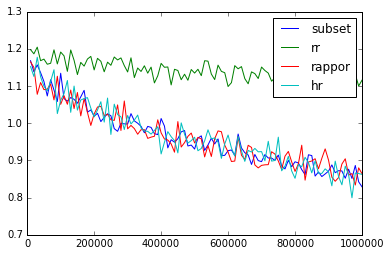

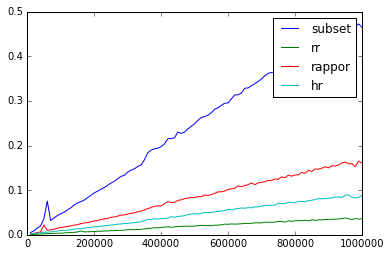

In [12]:
k = 100 #absz
eps = 1 # privacy_para
rep = 10 #repetition time for each point
points = 100 # total number of points
step_sz = 10000 # step size between two points
init = 1 #initial step
dist = 'Two_steps' # name of the distribution, select from below
                    #Two_steps, Uniform, Zipf, Dirchlet, Geometric

for eps in [0.1, 0.5, 1, 2, 5, 10]:
    test(k,eps,rep,points,step_sz,init,dist)

In [ ]:
time = datetime.datetime.now().strftime("%m_%d_%H_%M")
data = {
    'time' : time,
    'absz' : k,
    'privacy' : eps,
    'repetition' : rep,
    'indices' : indicies, # indices of each point (number of samples)
    'subset_error': l1_1, #l1 error for each point
    'rr_error': l1_2,
    'rappor_error': l1_3,
    'hr_error': l1_4,
    'subset_time': t1_1, #decoding time for each point
    'rr_time': t1_2,
    'rappor_time': t1_3,
    'hr_time': t1_4,
    'prob': prob,
    'dist': dist
}
para = 'k_{}_eps_{}_'.format(k,eps)
filename = 'data_' + para + time
io.savemat(filename,data)

In [ ]:
plt.plot(indicies[0:46], l1_1[0:46], label = 'subset')
plt.plot(l1_2[1:46], label = 'rr')
plt.plot(l1_3[1:46], label = 'rappor')
plt.plot(l1_4[1:46], label = 'hr')
plt.legend()

In [ ]:
plt.plot(t1_1[1:100], label = 'subset')
plt.plot(t1_2[1:100], label = 'rr')
plt.plot(t1_3[1:100], label = 'rappor')
plt.plot(t1_4[1:100], label = 'hr')
plt.legend()

In [ ]:
k = 100 #absz
n = 100000
eps = 1 # privacy_para

# prob = generate_geometric_distribution(k,0.8)
# prob = generate_uniform_distribution(k)
prob = generate_two_steps_distribution(k)
# prob = generate_Zipf_distribution(k,1.0)
# prob = generate_Dirchlet_distribution(k,1.0)

elements = range(0,k)
in_list = np.random.choice(elements, n, p=prob) #input symbols

In [ ]:
# Subsetselection
a = Subsetselection.Subsetselection(k,eps) 
#print (a.partsz)
#print (elements.type)
# print(type(in_list[9]))
outp = a.encode_string(in_list)
prob_est = a.decode_string(outp,n) # estimate the original underlying distribution
plt.plot(elements,prob)
plt.plot(elements,prob_est)
#plt.plot(prob_est)
print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
print ("prob_sum: ", str(sum(prob_est)))

In [ ]:
# k-rr
sample = Classic.randomized_response_encoder(in_list, eps, k)
(outp, temp) = np.histogram(sample,range(k+1))
#print outp
prob_est = Classic.normalized_standard_rr_decoder(outp,eps,n) # estimate the original underlying distribution
plt.plot(elements,prob)
plt.plot(elements,prob_est)
#plt.plot(prob_est)
print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
print ("prob_sum: ", str(sum(prob_est)))

In [ ]:
# k-rappor
sample = Classic.rappor_encoder(in_list, eps, k)
outp = np.sum(sample, axis=0)
prob_est = Classic.normalized_standard_rappor_decoder(outp,eps,n) # estimate the original underlying distribution
plt.plot(elements,prob)
plt.plot(elements,prob_est)
#plt.plot(prob_est)
print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
print ("prob_sum: ", str(sum(prob_est)))

In [ ]:
b = k2k_hadamard.Hadamard_Rand_2(k,eps) 
#print (a.partsz)
#print (elements.type)
# print(type(in_list[9]))
outp = b.encode_string(in_list)
#print outp
prob_est = b.decode_string(outp) # estimate the original underlying distribution
plt.plot(elements,prob)
plt.plot(elements,prob_est)
#plt.plot(prob_est)
print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
print ("prob_sum: ", str(sum(prob_est)))